In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/math482-2024-2025-1-hw-03/sample_submission.csv
/kaggle/input/math482-2024-2025-1-hw-03/train.csv
/kaggle/input/math482-2024-2025-1-hw-03/test.csv


In [2]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
traindf=pd.read_csv("/kaggle/input/math482-2024-2025-1-hw-03/train.csv")
testdf=pd.read_csv("/kaggle/input/math482-2024-2025-1-hw-03/test.csv")
traindf.isnull().sum() 
trainY=traindf["target"]
traindf.drop(["id"], axis=1, inplace=True)
testdf.drop(["id"], axis=1, inplace=True) #drop ids and extract labels

In [3]:
copy=traindf.copy()
copy2=traindf.copy()
copy.drop(["target"],axis=1, inplace=True)
categorical_columns = traindf.select_dtypes(include=['object']).columns #select numerical and categorical columns for specific exploratorty data analysis
numeric_columns = copy.select_dtypes(include=['number']).columns
traindf[categorical_columns]

,feature_03,feature_07,feature_11,feature_14,feature_16,feature_18,feature_19,feature_20
0,u,B1,xy,ij,C3,A2,ab,D4
1,NaN,B3,NaN,ij,C1,A4,ac,D1
2,u,B3,xy,ii,C2,A5,ab,D1
3,q,B6,yy,ji,C1,A8,ad,D1
4,t,B5,yy,jj,NaN,A7,NaN,NaN
...,...,...,...,...,...,...,...,...
29995,s,B2,NaN,ji,C3,A2,ac,D1
29996,q,B5,xx,ij,C3,A7,ab,D4
29997,s,B6,yx,ij,C5,A5,aa,D1
29998,r,B6,NaN,ji,C4,A7,ae,D4


In [4]:
for  col in categorical_columns:
    category_means = traindf.groupby(col)['target'].mean() #check the distribution of categorical columns to find out if there is an ordinary relation or not
    print(category_means.sort_values())

feature_03
u    1101.283430
s    1123.285007
q    1124.416177
p    1127.059847
t    1150.239394
r    1150.537786
Name: target, dtype: float64
feature_07
B1    1116.604299
B4    1121.923353
B2    1130.381694
B3    1131.159459
B6    1132.794767
B5    1142.128984
Name: target, dtype: float64
feature_11
xy    1116.367454
yx    1117.089159
yy    1140.632663
xx    1146.399702
Name: target, dtype: float64
feature_14
ij    1124.898162
ji    1128.959035
jj    1129.830736
ii    1134.050130
Name: target, dtype: float64
feature_16
C4    1121.232557
C3    1122.523295
C2    1123.243565
C1    1127.254313
C5    1146.093980
Name: target, dtype: float64
feature_18
A6    1116.867573
A1    1119.003539
A5    1124.504194
A8    1125.952556
A4    1130.137108
A7    1133.020358
A2    1133.408482
A3    1139.020063
Name: target, dtype: float64
feature_19
ae    1113.891509
ab    1117.949863
ac    1125.416430
ad    1137.492436
aa    1148.784135
Name: target, dtype: float64
feature_20
D6    1117.642400
D2    1120.38

In [5]:
traindf["feature_01"].describe()

count    27152.000000
mean       394.091653
std       1164.757698
min         10.000000
25%         35.010000
50%         59.430000
75%         84.380000
max       6428.390000
Name: feature_01, dtype: float64

<Axes: ylabel='Frequency'>

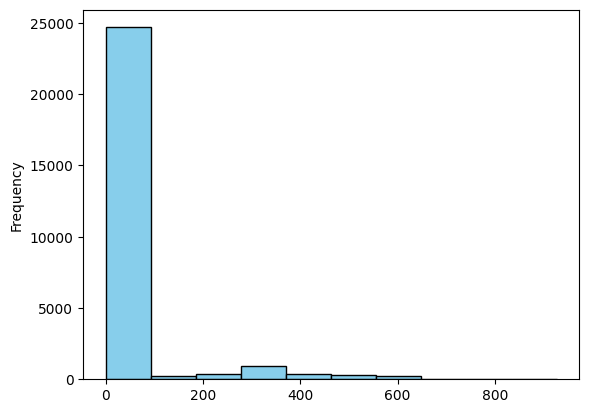

In [6]:
traindf["feature_17"].dropna().plot(kind='hist', bins=10, color='skyblue', edgecolor='black')

In [7]:
traindf.drop("target", axis=1, inplace=True)
for col in traindf.select_dtypes(include=['number']).columns: #handle NaN values by replacing them with median
    traindf[col] = traindf[col].fillna(traindf[col].median())

for col in traindf.select_dtypes(include='object').columns:
    most_frequent = traindf[col].mode()[0]                 #handle NaN values by replacingthem with most frequent values
    traindf[col] = traindf[col].fillna(most_frequent)    

In [8]:
for col in testdf.select_dtypes(include=['number']).columns:
    testdf[col] = testdf[col].fillna(testdf[col].median())

for col in testdf.select_dtypes(include='object').columns:
    most_frequent = testdf[col].mode()[0]
    testdf[col] = testdf[col].fillna(most_frequent)

In [9]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = df[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1                   # Interquartile range
    lower_bound = Q1 - 1.5 * IQR    # Lower bound for outliers
    upper_bound = Q3 + 1.5 * IQR    # Upper bound for outliers
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [10]:
outlier_summary = {}
for col in numeric_columns:
    if col != 'target':
        outliers = detect_outliers_iqr(traindf, col)
        outlier_summary[col] = len(outliers)

outlier_summary_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Outlier_Count'])
outlier_summary_df['Outlier_Proportion'] = outlier_summary_df['Outlier_Count'] / len(traindf)
outlier_summary_df.sort_values(by='Outlier_Proportion', ascending=False).head(10)

,Outlier_Count,Outlier_Proportion
feature_13,3944,0.131467
feature_09,3254,0.108467
feature_05,3251,0.108367
feature_12,3217,0.107233
feature_21,3059,0.101967
feature_08,2773,0.092433
feature_02,2719,0.090633
feature_04,2679,0.089300
feature_17,2677,0.089233
feature_06,2671,0.089033


In [11]:
for col in ['feature_13', 'feature_09', 'feature_21', 'feature_05', 'feature_09']:
    lower_cap = traindf[col].quantile(0.05)
    upper_cap = traindf[col].quantile(0.95)
    traindf[col] = traindf[col].clip(lower=lower_cap, upper=upper_cap)

In [12]:
traindf.isna().sum()

feature_01    0
feature_02    0
feature_03    0
feature_04    0
feature_05    0
feature_06    0
feature_07    0
feature_08    0
feature_09    0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
feature_20    0
feature_21    0
dtype: int64

In [13]:
numeric_columns = traindf.select_dtypes(include=['number']).columns
from sklearn import preprocessing 
min_max_scaler = preprocessing.MinMaxScaler()
trainvardf=min_max_scaler.fit_transform(traindf[numeric_columns])
#Scaling data to check and compare variances of features

In [14]:
df=pd.DataFrame(trainvardf,columns=numeric_columns) #Checking for monotonic relations between features and target
df["target"]=trainY
df.corr(method='spearman')["target"]

feature_01   -0.006534
feature_02   -0.000268
feature_04    0.336026
feature_05   -0.003597
feature_06   -0.000944
feature_08    0.460693
feature_09    0.000872
feature_10   -0.001485
feature_12   -0.003343
feature_13   -0.008672
feature_15    0.558059
feature_17    0.005597
feature_21   -0.006219
target        1.000000
Name: target, dtype: float64

In [15]:
#Searching for features that have low variance which could be redundant
pd.DataFrame(trainvardf, columns=numeric_columns).var()

feature_01    0.030039
feature_02    0.001277
feature_04    0.001955
feature_05    0.054341
feature_06    0.011801
feature_08    0.023644
feature_09    0.053731
feature_10    0.028935
feature_12    0.002554
feature_13    0.056149
feature_15    0.006937
feature_17    0.013943
feature_21    0.057301
dtype: float64

<Axes: >

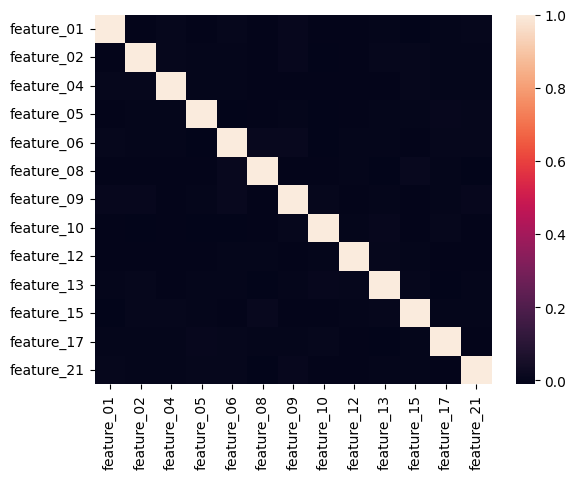

In [16]:
import seaborn as sns
corr=traindf[numeric_columns].corr() #checking for correlation between features (high correlation between 2 variables indicates one of them could be dropped)
sns.heatmap(corr)

<Axes: >

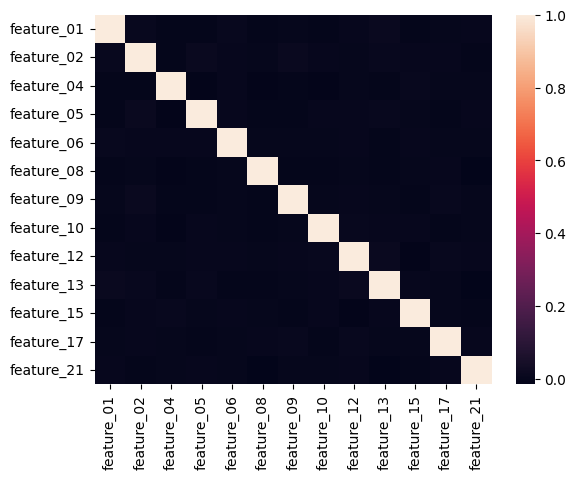

In [17]:
corr=traindf[numeric_columns].corr(method='spearman') 
sns.heatmap(corr)

In [18]:
columns=traindf.columns
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled=scaler.fit_transform(traindf[numeric_columns])
scaled=pd.DataFrame(scaled,columns=numeric_columns)

In [19]:
traindf.drop(["feature_02","feature_09","feature_10"], axis=1,inplace=True)

In [20]:
testdf.drop(["feature_02","feature_09","feature_10"], axis=1,inplace=True)

In [21]:
from sklearn.feature_selection import mutual_info_regression
numeric_columns=traindf.select_dtypes(include=["number"]).columns
mi_scores = mutual_info_regression(scaled, trainY)
mi_results = pd.DataFrame({'Feature': scaled.columns, 'MI Score': mi_scores})
print(mi_results)

       Feature  MI Score
0   feature_01  0.000000
1   feature_02  0.003649
2   feature_04  0.081218
3   feature_05  0.000000
4   feature_06  0.000000
5   feature_08  0.214434
6   feature_09  0.000000
7   feature_10  0.001962
8   feature_12  0.000000
9   feature_13  0.000000
10  feature_15  0.306039
11  feature_17  0.000000
12  feature_21  0.000000


In [22]:
traindf.drop(["feature_01","feature_05","feature_06","feature_12","feature_13","feature_17","feature_21"], axis=1, inplace=True)

In [23]:
testdf.drop(["feature_01","feature_05","feature_06","feature_12","feature_13","feature_17","feature_21"], axis=1, inplace=True)

In [24]:
traindf[categorical_columns].nunique()

feature_03    6
feature_07    6
feature_11    4
feature_14    4
feature_16    5
feature_18    8
feature_19    5
feature_20    6
dtype: int64

In [25]:
traindf["feature_18"].unique()

array(['A2', 'A4', 'A5', 'A8', 'A7', 'A1', 'A3', 'A6'], dtype=object)

In [26]:
order_dict={
    "feature_20":["D1","D2","D3","D4","D5","D6"],
    "feature_07":["B1","B2","B3","B4","B5","B6"], #ordering features for encoding
    "feature_16":["C1","C2","C3","C4","C5"],
    "feature_18":["A1","A2","A3","A4","A5","A6","A7","A8"]
}

In [27]:
for col, order in order_dict.items():
    traindf[col] = pd.Categorical(traindf[col], categories=order, ordered=True) 
    traindf[f"{col}_encoded"] = traindf[col].cat.codes

In [28]:
for col, order in order_dict.items():
    testdf[col] = pd.Categorical(testdf[col], categories=order, ordered=True)
    testdf[f"{col}_encoded"] = testdf[col].cat.codes

In [29]:
traindf.drop(["feature_20","feature_07","feature_16","feature_18"], axis=1, inplace=True)

In [30]:
testdf.drop(["feature_20","feature_07","feature_16","feature_18"], axis=1, inplace=True)

In [31]:
#one-hot encoding remaining categorical feautes

In [32]:
traindf=pd.get_dummies(traindf, columns=['feature_03', 'feature_11',"feature_14","feature_19"], drop_first=True)

In [33]:
testdf=pd.get_dummies(testdf, columns=['feature_03', 'feature_11',"feature_14","feature_19"], drop_first=True)

In [34]:
for col in traindf.columns:
    if(any([x in col for x in ['feature_03', 'feature_11',"feature_14","feature_19"]])):
        traindf[col]=traindf[col].map({True:1, False:0})
traindf #changing boolean values with integers for model compatibility

,feature_04,feature_08,feature_15,feature_20_encoded,feature_07_encoded,feature_16_encoded,feature_18_encoded,feature_03_q,feature_03_r,feature_03_s,...,feature_11_xy,feature_11_yx,feature_11_yy,feature_14_ij,feature_14_ji,feature_14_jj,feature_19_ab,feature_19_ac,feature_19_ad,feature_19_ae
0,-28.35,102.89,5.29,3,0,2,1,0,0,0,...,1,0,0,1,0,0,1,0,0,0
1,-14.07,106.68,-12.72,0,2,0,3,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,-8.50,70.79,-3.47,0,2,1,4,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,0.32,90.18,31.65,0,5,0,7,1,0,0,...,0,0,1,0,1,0,0,0,1,0
4,-32.25,119.19,-12.25,0,4,0,6,0,0,0,...,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,7822.04,110.81,-20.34,0,1,2,1,0,0,1,...,0,0,0,0,1,0,0,1,0,0
29996,32.65,102.89,-0.16,3,4,2,6,1,0,0,...,0,0,0,1,0,0,1,0,0,0
29997,0.32,67.71,411.17,0,5,4,4,0,0,1,...,0,1,0,1,0,0,0,0,0,0
29998,-36.70,60.69,13.01,3,5,3,6,0,1,0,...,0,0,0,0,1,0,0,0,0,1


In [35]:
for col in testdf.columns:
    if(any([x in col for x in ['feature_03', 'feature_11',"feature_14","feature_19"]])):
        testdf[col]=testdf[col].map({True:1, False:0})
traindf

,feature_04,feature_08,feature_15,feature_20_encoded,feature_07_encoded,feature_16_encoded,feature_18_encoded,feature_03_q,feature_03_r,feature_03_s,...,feature_11_xy,feature_11_yx,feature_11_yy,feature_14_ij,feature_14_ji,feature_14_jj,feature_19_ab,feature_19_ac,feature_19_ad,feature_19_ae
0,-28.35,102.89,5.29,3,0,2,1,0,0,0,...,1,0,0,1,0,0,1,0,0,0
1,-14.07,106.68,-12.72,0,2,0,3,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,-8.50,70.79,-3.47,0,2,1,4,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,0.32,90.18,31.65,0,5,0,7,1,0,0,...,0,0,1,0,1,0,0,0,1,0
4,-32.25,119.19,-12.25,0,4,0,6,0,0,0,...,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,7822.04,110.81,-20.34,0,1,2,1,0,0,1,...,0,0,0,0,1,0,0,1,0,0
29996,32.65,102.89,-0.16,3,4,2,6,1,0,0,...,0,0,0,1,0,0,1,0,0,0
29997,0.32,67.71,411.17,0,5,4,4,0,0,1,...,0,1,0,1,0,0,0,0,0,0
29998,-36.70,60.69,13.01,3,5,3,6,0,1,0,...,0,0,0,0,1,0,0,0,0,1


In [36]:
mi_scores = mutual_info_regression(traindf, trainY)
mi_results = pd.DataFrame({'Feature': traindf.columns, 'MI Score': mi_scores})
print(mi_results) #checking mutual info to see which features are more effective

               Feature  MI Score
0           feature_04  0.081195
1           feature_08  0.214562
2           feature_15  0.306185
3   feature_20_encoded  0.002987
4   feature_07_encoded  0.001570
5   feature_16_encoded  0.004454
6   feature_18_encoded  0.001381
7         feature_03_q  0.000766
8         feature_03_r  0.000000
9         feature_03_s  0.000201
10        feature_03_t  0.000000
11        feature_03_u  0.001871
12       feature_11_xy  0.000000
13       feature_11_yx  0.000000
14       feature_11_yy  0.000742
15       feature_14_ij  0.002189
16       feature_14_ji  0.000000
17       feature_14_jj  0.001492
18       feature_19_ab  0.000585
19       feature_19_ac  0.000000
20       feature_19_ad  0.000000
21       feature_19_ae  0.000000


In [37]:
traindf.drop(["feature_19_ae","feature_19_ad","feature_19_ac","feature_11_yx","feature_11_xy","feature_03_t","feature_03_s","feature_03_r"], axis=1, inplace=True)
traindf

,feature_04,feature_08,feature_15,feature_20_encoded,feature_07_encoded,feature_16_encoded,feature_18_encoded,feature_03_q,feature_03_u,feature_11_yy,feature_14_ij,feature_14_ji,feature_14_jj,feature_19_ab
0,-28.35,102.89,5.29,3,0,2,1,0,1,0,1,0,0,1
1,-14.07,106.68,-12.72,0,2,0,3,0,1,0,1,0,0,0
2,-8.50,70.79,-3.47,0,2,1,4,0,1,0,0,0,0,1
3,0.32,90.18,31.65,0,5,0,7,1,0,1,0,1,0,0
4,-32.25,119.19,-12.25,0,4,0,6,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,7822.04,110.81,-20.34,0,1,2,1,0,0,0,0,1,0,0
29996,32.65,102.89,-0.16,3,4,2,6,1,0,0,1,0,0,1
29997,0.32,67.71,411.17,0,5,4,4,0,0,0,1,0,0,0
29998,-36.70,60.69,13.01,3,5,3,6,0,0,0,0,1,0,0


In [38]:
testdf.drop(["feature_19_ae","feature_19_ad","feature_19_ac","feature_11_yx","feature_11_xy","feature_03_t","feature_03_s","feature_03_r"], axis=1, inplace=True)

In [39]:
scaler = StandardScaler()
traindf = scaler.fit_transform(traindf)  
testdf = scaler.transform(testdf)

In [40]:
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(traindf, trainY, test_size=0.2, random_state=42)

In [41]:
traindf

array([[-0.02832855, -0.29816053,  0.01266248, ..., -0.65262798,
        -0.5008332 ,  2.1317274 ],
       [-0.0154243 , -0.29659351, -0.01776942, ..., -0.65262798,
        -0.5008332 , -0.46910313],
       [-0.01039092, -0.31143261, -0.00213949, ..., -0.65262798,
        -0.5008332 ,  2.1317274 ],
       ...,
       [-0.00242065, -0.31270607,  0.69848698, ..., -0.65262798,
        -0.5008332 , -0.46910313],
       [-0.03587411, -0.31560856,  0.02570714, ...,  1.53226651,
        -0.5008332 , -0.46910313],
       [-0.02510249, -0.29538207, -0.03485251, ...,  1.53226651,
        -0.5008332 , -0.46910313]])

In [ ]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf', C=10, epsilon=0.1))
])

pipeline.fit(X_train, y_train)
y_pred_pipeline = pipeline.predict(X_test)
mse_pipeline = mean_squared_error(y_test, y_pred_pipeline)
print(f"Pipeline SVR Mean Squared Error: {mse_pipeline}")

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 15, 20],
    'epsilon': [0.01,0.1, 0.2, 0.5,1],
    'kernel': ['rbf', 'poly']
}

grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

In [ ]:
best_svr_model = grid_search.best_estimator_
y_pred = best_svr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

In [ ]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

y_pred = poly_model.predict(X_test_poly)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, regularizers, optimizers, callbacks

checkpoint = ModelCheckpoint(
    filepath="/kaggle/working/weights.keras",
    monitor="val_loss",        
    save_best_only=True,
    mode="min",                
    verbose=1                  
)

model = tf.keras.Sequential([
    layers.InputLayer(shape=(14,)),  
    layers.Dense(units=140, activation="relu", kernel_regularizer=regularizers.l2(0.01)),#kernel regularizer for preventing overfitting
    layers.BatchNormalization(), #for more stable activation
    layers.Dropout(0.3), #dropout for preventing overfitting
    layers.Dense(units=90, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(), 
    layers.Dropout(0.3), 
    layers.Dense(units=16, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(units=1)  
])

model.compile(
    optimizer=optimizers.RMSprop(learning_rate=0.0001, momentum=0.15),
    loss="mse",
    metrics=["mse"])  


history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    batch_size=80, epochs=1200, callbacks=[checkpoint])


Epoch 1/1200
294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1718200.6250 - mse: 1718199.1250
Epoch 1: val_loss improved from inf to 1739760.50000, saving model to /kaggle/working/weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1718119.6250 - mse: 1718118.0000 - val_loss: 1739760.5000 - val_mse: 1739758.7500
Epoch 2/1200
294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1697202.0000 - mse: 1697200.5000
Epoch 2: val_loss improved from 1739760.50000 to 1726954.87500, saving model to /kaggle/working/weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1697418.6250 - mse: 1697417.1250 - val_loss: 1726954.8750 - val_mse: 1726953.5000
Epoch 3/1200
291/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1699011.3750 - mse: 1699009.7500
Epoch 3: val_loss improved from 1726954.87500 to 1713616.50000, saving model to /kaggle/working/weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1698932.5000 - mse: 1698930.7500 - val_loss: 1713616.5000 - val_mse: 1713614.6250
Ep

In [43]:
y_pred=model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean Squared Error: 150287.19266053362


In [ ]:
prediction=model.predict(testdf)

In [55]:
#load model with best weights according to validation loss
from tensorflow.keras.models import load_model
best_model = load_model("/kaggle/working/weights.keras")
prediction = best_model.predict(testdf)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [57]:
import csv
arr=[]
for i in range(len(prediction)):
    arr.append([len(traindf)+i+1,prediction[i][0]])
writer = csv.writer(open("/kaggle/working/submission.csv", 'w'))
for row in arr:
    writer.writerow(row)